In [1]:
    # a script to run the spike interface on Diao's data with visualisation
#744

#import the necessary packages
from pathlib import Path
import platform
import os
import shutil
import argparse
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.sorters
import spikeinterface.full as si
import  scipy.signal
import spikeinterface.extractors as se
import spikeinterface.comparison
import spikeinterface.exporters
import spikeinterface.curation
import spikeinterface.widgets 
import docker


In [7]:
#grab recordings from the server to local machine (Beast)
base_folder = '/mnt/rds01/ibn-vision/DATA/SUBJECTS/'
mouse = 'M23032'
date = '20230718'
# get all the recordings on that day
ephys_folder = base_folder + mouse + '/ephys/' + date +'/'
# allocate destination folder and move the ephys folder on the server to Beast lab user
dst_folder = "/home/lab/spikeinterface_sorting/temp_data"
#dst_folder = ephys_folder + 'sorting'

In [3]:
# iterate over all directories in source folder
for dirname in os.listdir(ephys_folder):
    # check if '_g' is in the directory name
    #only grab recording folders - there might be some other existing folders for analysis or sorted data
    if '_g' in dirname:
        # construct full directory path
        source = os.path.join(ephys_folder, dirname)
        destination = os.path.join(dst_folder, dirname)
        # copy the directory to the destination folder
        shutil.copytree(source, destination)
        

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/rds01/ibn-vision/DATA/SUBJECTS/M23032/ephys/20230718/'

In [4]:
stream_names, stream_ids = si.get_neo_streams('spikeglx',dst_folder)
print(stream_names)
print(stream_ids)

['imec0.ap', 'imec1.ap', 'imec0.lf', 'imec1.lf']
['imec0.ap', 'imec1.ap', 'imec0.lf', 'imec1.lf']


In [5]:
#load first probe from beast folder - MEC probe for Diao
probe0_raw = si.read_spikeglx(dst_folder,stream_name=stream_names[0])
print(probe0_raw)
#Load second probe - V1 probe
probe1_raw = si.read_spikeglx(dst_folder,stream_name = stream_names[1])
print(probe1_raw)

#plot channel maps of the probes
#fig, ax =plt.subplots(figsize=(15, 10))
#si.plot_probe_map(probe0_raw,ax=ax,with_channels_ids=True)
#ax.set_ylim(-100,100)

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 5 segments - 112,798,213 samples 
                            3,759.94s (1.04 hours) - int16 dtype - 80.68 GiB
Segments:
Samples:   11,119,669 | 66,708,444 | 4,003,680 | 18,327,348 | 12,639,072
Durations: 370.66s (6.18 minutes) | 2,223.61s (37.06 minutes) | 133.46s (2.22 minutes) | 610.91s (10.18 minutes) | 421.30s (7.02 minutes)
Memory:    7.95 GiB | 47.71 GiB | 2.86 GiB | 13.11 GiB | 9.04 GiB
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 5 segments - 112,799,137 samples 
                            3,759.97s (1.04 hours) - int16 dtype - 80.68 GiB
Segments:
Samples:   11,119,801 | 66,708,624 | 4,003,872 | 18,327,540 | 12,639,300
Durations: 370.66s (6.18 minutes) | 2,223.62s (37.06 minutes) | 133.46s (2.22 minutes) | 610.92s (10.18 minutes) | 421.31s (7.02 minutes)
Memory:    7.95 GiB | 47.71 GiB | 2.86 GiB | 13.11 GiB | 9.04 GiB


In [6]:
#several preprocessing steps and concatenation of the recordings

#highpass filter - threhsold at 300Hz
probe0_highpass = si.highpass_filter(probe0_raw,freq_min=300.)
#detect bad channels
bad_channel_ids, channel_labels = si.detect_bad_channels(probe0_highpass)
#remove bad channels if wanted
probe0_remove_channels = probe0_highpass.remove_channels(bad_channel_ids)
print('bad_channel_ids',bad_channel_ids)
#phase shift correction - equivalent to T-SHIFT in catGT
probe0_phase_shift = si.phase_shift(probe0_remove_channels)
probe0_common_reference = si.common_reference(probe0_phase_shift,operator='median',reference='global')
probe0_preprocessed = probe0_common_reference
probe0_cat = si.concatenate_recordings([probe0_preprocessed])
print('probe0_preprocessed',probe0_preprocessed)
print('probe0 concatenated',probe0_cat)

probe1_highpass = si.highpass_filter(probe1_raw,freq_min=300.)
bad_channel_ids, channel_labels = si.detect_bad_channels(probe1_highpass)
probe1_remove_channels = probe1_highpass.remove_channels(bad_channel_ids)
print('bad_channel_ids',bad_channel_ids)
probe1_phase_shift = si.phase_shift(probe1_remove_channels)
probe1_common_reference = si.common_reference(probe1_phase_shift,operator='median',reference='global')
probe1_preprocessed = probe1_common_reference
probe1_cat = si.concatenate_recordings([probe1_preprocessed])
print('probe1_preprocessed',probe0_preprocessed)
print('probe1 concatenated',probe1_cat)

bad_channel_ids ['imec0.ap#AP191' 'imec0.ap#AP352' 'imec0.ap#AP353' 'imec0.ap#AP354'
 'imec0.ap#AP355' 'imec0.ap#AP356' 'imec0.ap#AP357' 'imec0.ap#AP358'
 'imec0.ap#AP359' 'imec0.ap#AP360' 'imec0.ap#AP361' 'imec0.ap#AP362'
 'imec0.ap#AP363' 'imec0.ap#AP364' 'imec0.ap#AP365' 'imec0.ap#AP366'
 'imec0.ap#AP367' 'imec0.ap#AP368' 'imec0.ap#AP369' 'imec0.ap#AP370'
 'imec0.ap#AP371' 'imec0.ap#AP372' 'imec0.ap#AP373' 'imec0.ap#AP374'
 'imec0.ap#AP375' 'imec0.ap#AP376' 'imec0.ap#AP377' 'imec0.ap#AP378'
 'imec0.ap#AP379' 'imec0.ap#AP380' 'imec0.ap#AP381' 'imec0.ap#AP382'
 'imec0.ap#AP383']
probe0_preprocessed CommonReferenceRecording: 351 channels - 30.0kHz - 5 segments - 112,798,213 samples 
                          3,759.94s (1.04 hours) - int16 dtype - 73.75 GiB
Segments:
Samples:   11,119,669 | 66,708,444 | 4,003,680 | 18,327,348 | 12,639,072
Durations: 370.66s (6.18 minutes) | 2,223.61s (37.06 minutes) | 133.46s (2.22 minutes) | 610.91s (10.18 minutes) | 421.30s (7.02 minutes)
Memory:    7

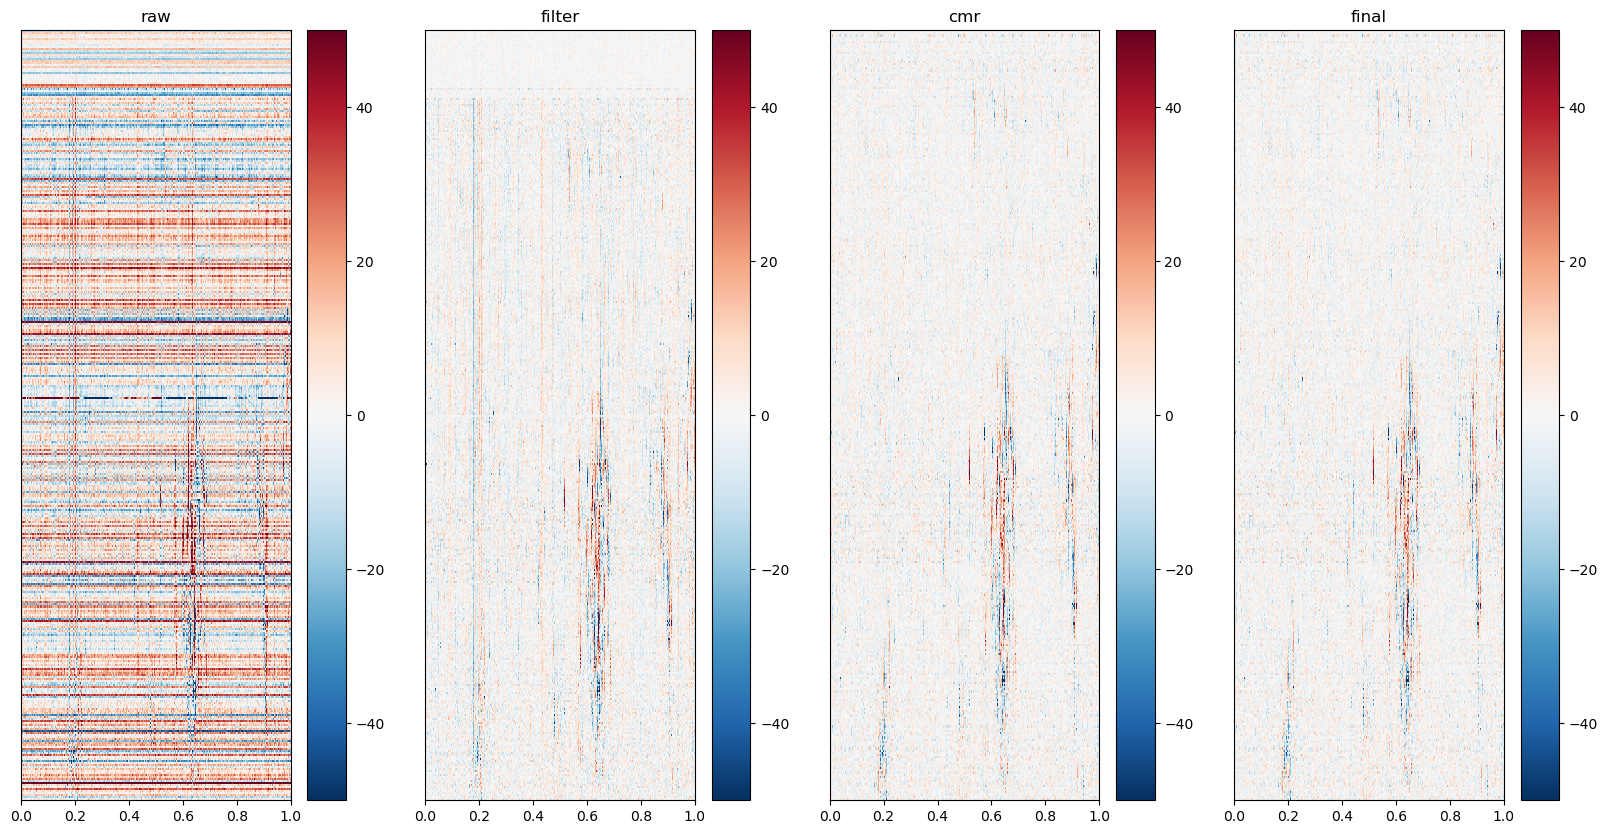

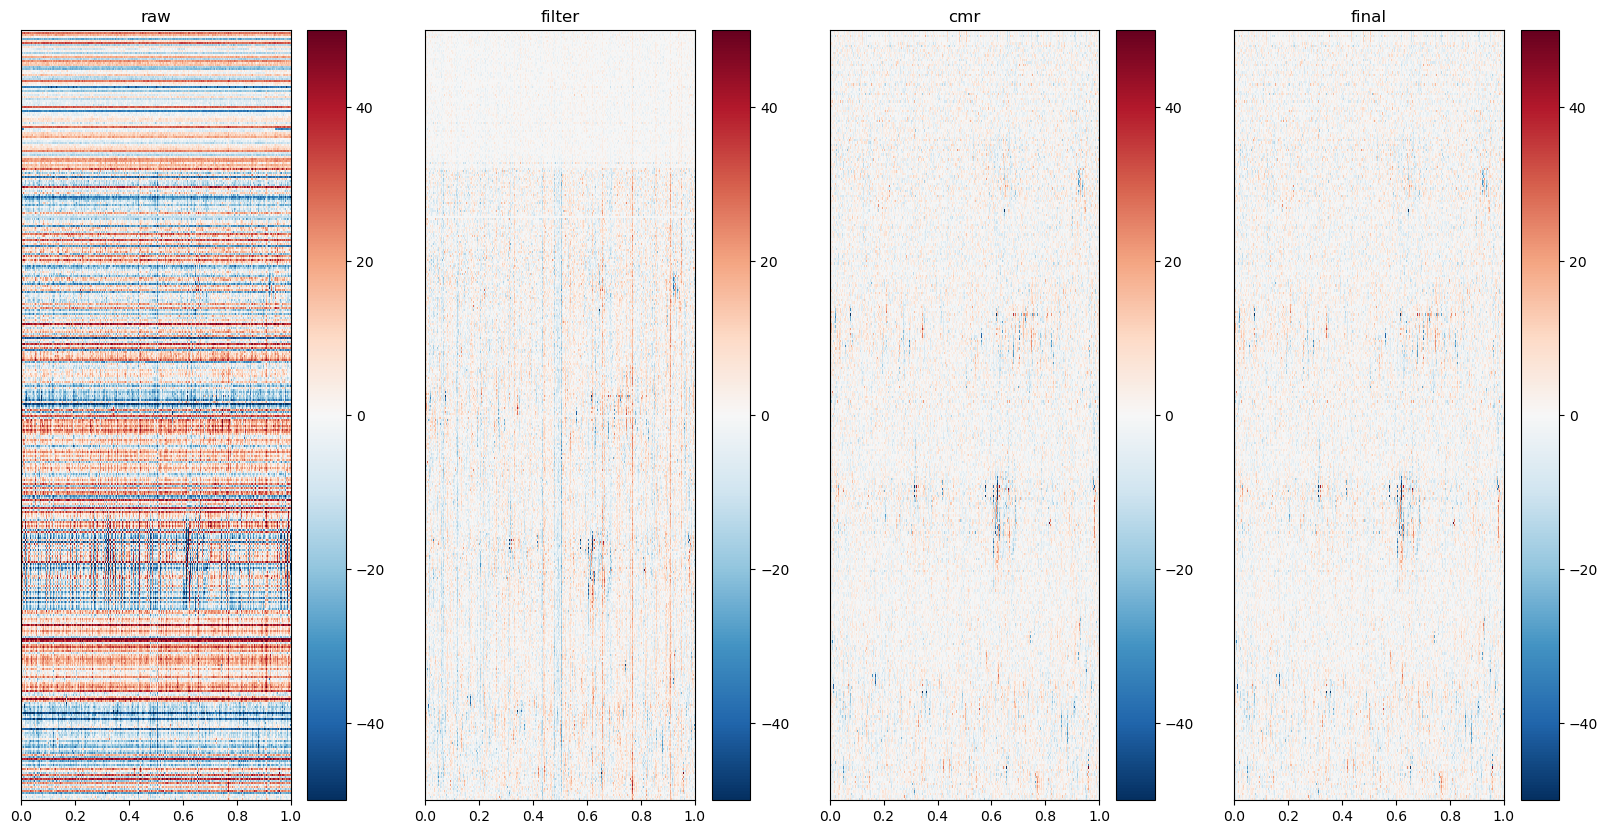

In [7]:
#visualisation of preprocessing steps

#First Probe
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))
#concatenated recordings from each step of preprocessing and compare
si.plot_traces(si.concatenate_recordings([probe0_raw]), backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(si.concatenate_recordings([probe0_highpass]), backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(si.concatenate_recordings([probe0_common_reference]), backend='matplotlib',  clim=(-50, 50), ax=axs[2])
si.plot_traces(si.concatenate_recordings([probe0_preprocessed]), backend='matplotlib',  clim=(-50, 50), ax=axs[3])
for i, label in enumerate(('raw','filter', 'cmr', 'final')):
    axs[i].set_title(label)



#Second Probe
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))
#concatenated recordings from each step of preprocessing and compare
si.plot_traces(si.concatenate_recordings([probe1_raw]), backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(si.concatenate_recordings([probe1_highpass]), backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(si.concatenate_recordings([probe1_common_reference]), backend='matplotlib',  clim=(-50, 50), ax=axs[2])
si.plot_traces(si.concatenate_recordings([probe1_preprocessed]), backend='matplotlib',  clim=(-50, 50), ax=axs[3])
for i, label in enumerate(('raw','filter', 'cmr', 'final')):
    axs[i].set_title(label)

Text(0.5, 0, 'Second Probe noise  [microV]')

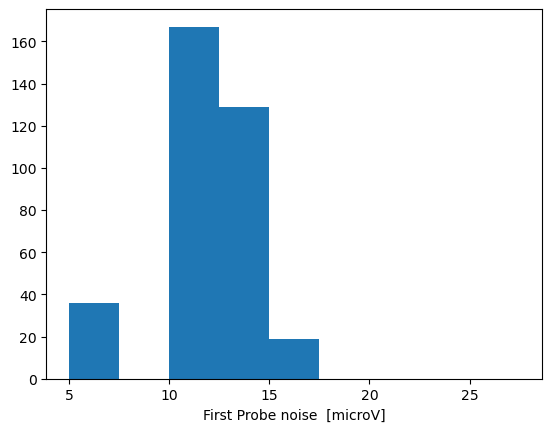

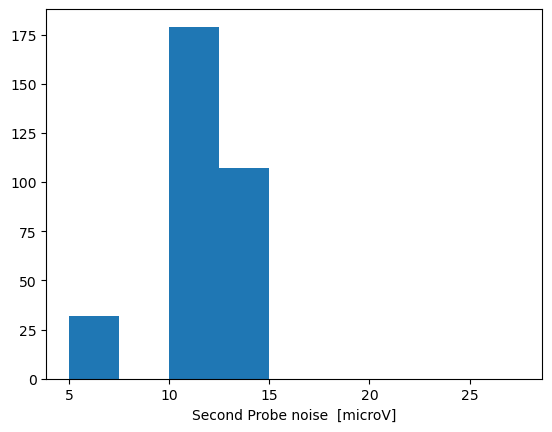

In [8]:
#Check noise level
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
#First Probe
probe0_noise_levels_microV = si.get_noise_levels(probe0_cat, return_scaled=True)
probe0_noise_levels_int16 = si.get_noise_levels(probe0_cat, return_scaled=False)
fig, ax = plt.subplots()
_ = ax.hist(probe0_noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('First Probe noise  [microV]')

#Second Probe
probe1_noise_levels_microV = si.get_noise_levels(probe1_cat, return_scaled=True)
probe1_noise_levels_int16 = si.get_noise_levels(probe1_cat, return_scaled=False)
fig, ax = plt.subplots()
_ = ax.hist(probe1_noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('Second Probe noise  [microV]')

detect peaks using locally_exclusive:   0%|          | 0/3760 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/3760 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/3760 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/3760 [00:00<?, ?it/s]

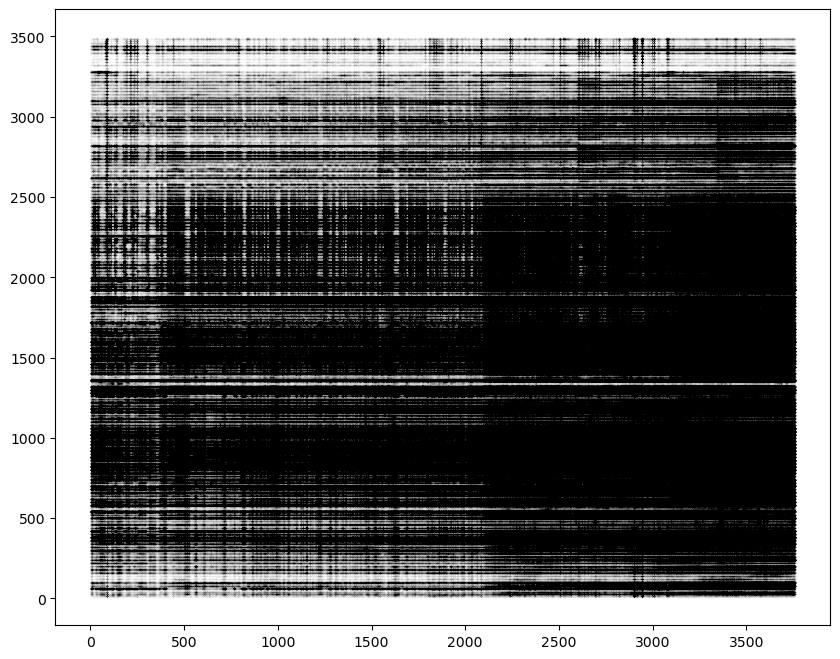

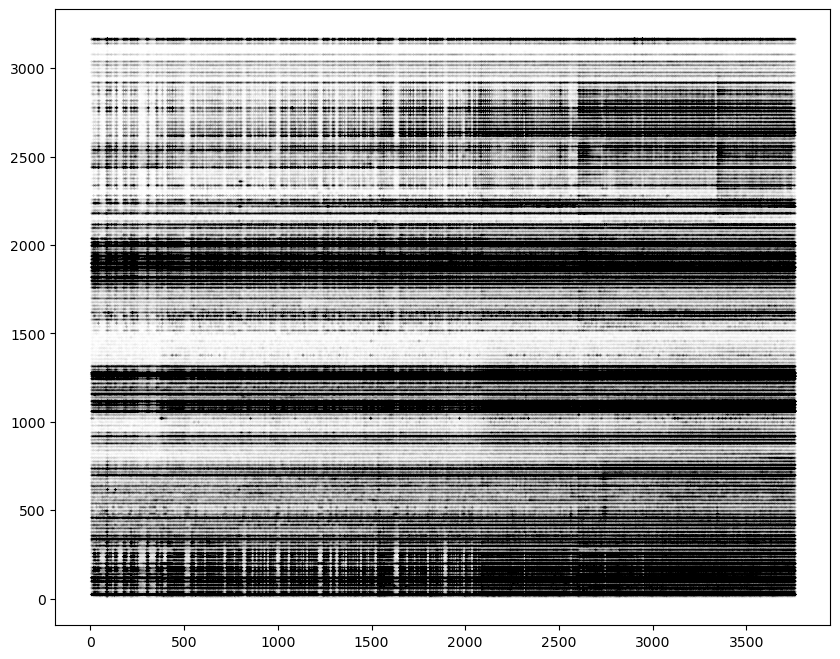

In [9]:
#Check motion drifts
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_peaks = detect_peaks(probe0_cat,  method='locally_exclusive', noise_levels=probe0_noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
probe0_peaks

from spikeinterface.sortingcomponents.peak_localization import localize_peaks

probe0_peak_locations = localize_peaks(probe0_cat, probe0_peaks, method='center_of_mass', radius_um=50., **job_kwargs)

# check for drifts
probe0_peaks


fs = probe0_cat.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(probe0_peaks['sample_index'] / fs, probe0_peak_locations['y'], color='k', marker='.',  alpha=0.002,s=1.3)


job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe1_peaks = detect_peaks(probe1_cat,  method='locally_exclusive', noise_levels=probe1_noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
probe1_peaks


probe1_peak_locations = localize_peaks(probe1_cat, probe1_peaks, method='center_of_mass', radius_um=50., **job_kwargs)

# check for drifts

fs = probe1_cat.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(probe1_peaks['sample_index']/fs, probe1_peak_locations['y'], color='k', marker='.',  alpha=0.002,s=1.3)

s)

detect and localize:   0%|          | 0/3760 [00:00<?, ?it/s]

detect and localize:   0%|          | 0/3760 [00:00<?, ?it/s]

Text(0.5, 1.0, 'probe1_motion_corrected')

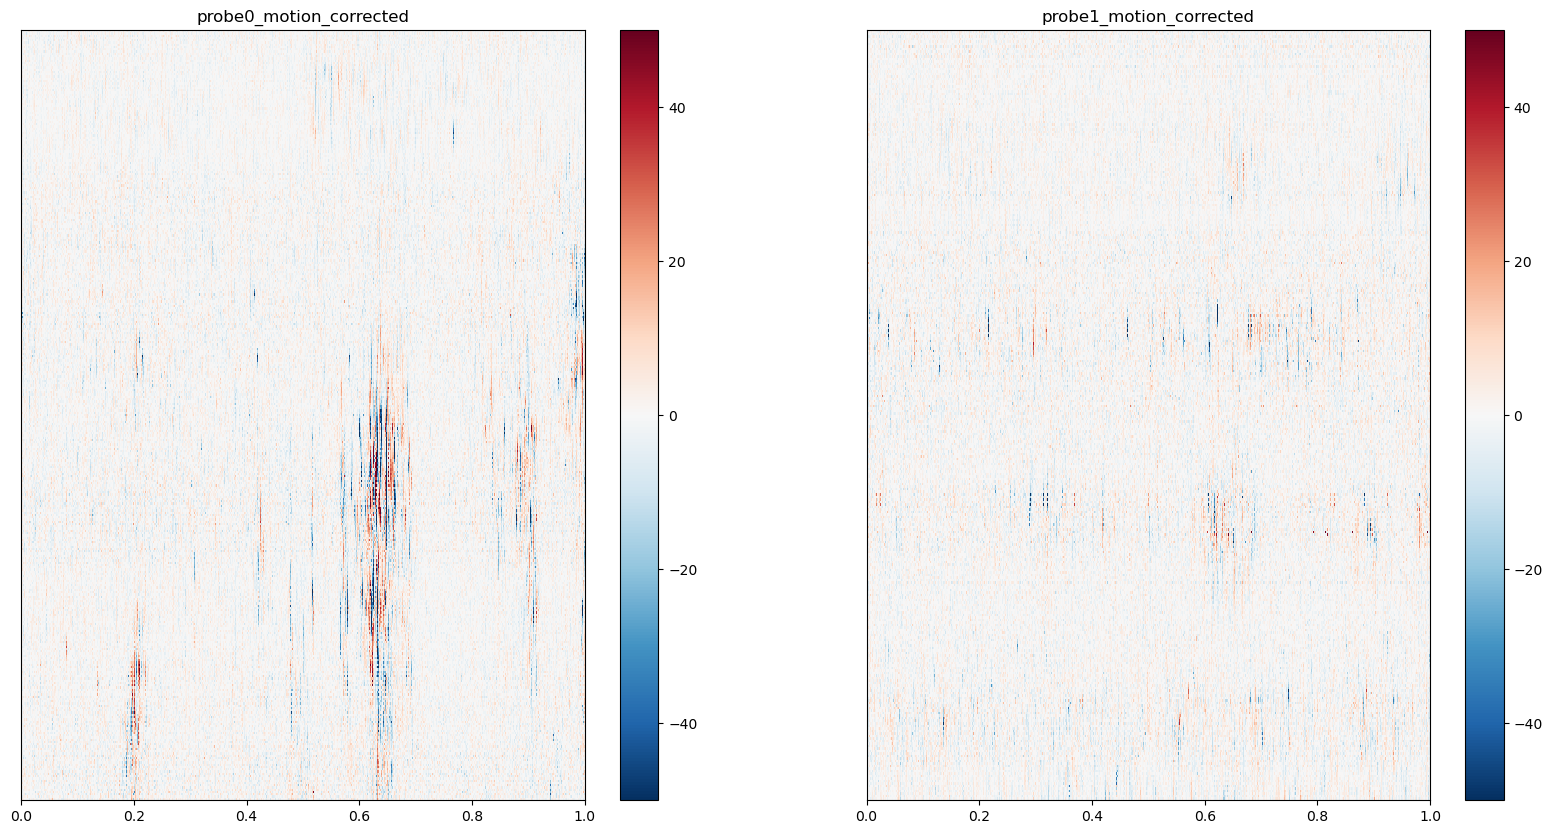

In [11]:
#motion correction if needed
#this is nonrigid correction - need to do parallel computing to speed up
job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_nonrigid_accurate = si.correct_motion(recording=probe0_cat, preset="nonrigid_accurate",**job_kwargs)
probe1_nonrigid_accurate = si.correct_motion(recording=probe1_cat, preset="nonrigid_accurate",**job_kwargs)

#kilosort like to mimic kilosort - no need if you are just running kilosort
#probe0_kilosort_like = correct_motion(recording=probe0_cat, preset="kilosort_like")
#probe1_kilosort_like = correct_motion(recording=probe1_cat, preset="kilosort_like")
#First Probe
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
si.plot_traces(probe0_nonrigid_accurate, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(probe1_nonrigid_accurate, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
axs[0].set_title('probe0_motion_corrected')
axs[1].set_title('probe1_motion_corrected')

In [13]:
#save preprocessed bin file before sorting

job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_preprocessed_corrected = probe0_nonrigid_accurate.save(folder=dst_folder+'/probe0_preprocessed', format='binary', **job_kwargs)
probe1_preprocessed_corrected = probe1_nonrigid_accurate.save(folder=dst_folder+'/probe1_preprocessed', format='binary', **job_kwargs)



write_binary_recording with n_jobs = 20 and chunk_size = 30000


write_binary_recording:   0%|          | 0/3760 [00:00<?, ?it/s]

write_binary_recording with n_jobs = 20 and chunk_size = 30000


write_binary_recording:   0%|          | 0/3760 [00:02<?, ?it/s]

In [17]:

#load preproceesed binary file if stopped at this point
#dst_folder = "/home/lab/spikeinterface_sorting/temp_data"
#probe0_preprocessed_corrected = spikeinterface.core.read_binary(file_paths=dst_folder+'/probe0_preprocessed')
#probe1_preprocessed_corrected = spikeinterface.core.read_binary(file_paths=dst_folder+'/probe1_preprocessed')

SyntaxError: invalid syntax (1912973816.py, line 1)

In [21]:
''' prepare sorters - currently using the default parameters and motion correction is turned off as it was corrected already above
    you can check if the parameters using:
    params = get_default_sorter_params('kilosort3')
print("Parameters:\n", params)

desc = get_sorter_params_description('kilosort3')
print("Descriptions:\n", desc)

Beware that moutainsort5 is commented out as the sorter somehow stops midway with no clue - currently raising this issue on their github page
'''

#something went wrong with docker running multiple sorters with parallel processing after the hard drive incident - so running sorters one by one...
probe0_KS2_5 = si.run_sorter(sorter_name= 'kilosort2_5',recording=probe0_preprocessed_corrected,output_folder=dst_folder+'/probe0/sorters/kilosort2_5/',docker_image="spikeinterface/kilosort2_5-compiled-base:latest",do_correction=False)

In [22]:
probe1_KS2_5 = si.run_sorter(sorter_name= 'kilosort2_5',recording=probe1_preprocessed_corrected,output_folder=dst_folder+'/probe1/sorters/kilosort2_5/',docker_image="spikeinterface/kilosort2_5-compiled-base:latest",do_correction=False)

In [23]:
probe0_KS3 = si.run_sorter(sorter_name= 'kilosort3',recording=probe0_preprocessed_corrected,output_folder=dst_folder+'/probe0/sorters/kilosort3/',docker_image="spikeinterface/kilosort3-compiled-base:latest",do_correction=False)

In [24]:
probe1_KS3 = si.run_sorter(sorter_name= 'kilosort3',recording=probe1_preprocessed_corrected,output_folder=dst_folder+'/probe1/sorters/kilosort3/',docker_image="spikeinterface/kilosort3-compiled-base:latest",do_correction=False)

In [ ]:
#start sorting in parallel
#sorter list
# job_list = [
#   {'sorter_name':'kilosort2_5','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/kilosort2_5/','docker_image':"spikeinterface/kilosort2_5-compiled-base:latest",'do_correction':False},#'spikeinterface/kilosort2_5-compiled-base'
#   {'sorter_name':'kilosort3','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/kilosort3/','docker_image':"spikeinterface/kilosort-compiled-base:latest",'do_correction':False},
#  # {'sorter_name':'mountainsort5','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/mountainsort5/','docker_image':True},
#     {'sorter_name':'kilosort2_5','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/kilosort2_5/','docker_image':"spikeinterface/kilosort2_5-compiled-base:latest",'do_correction':False},
#   {'sorter_name':'kilosort3','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/kilosort3/','docker_image':"spikeinterface/kilosort-compiled-base:latest",'do_correction':False},
#  # {'sorter_name':'mountainsort5','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/mountainsort5/','docker_image':True},
# ]
# #run sorters in parallel
# sortings = si.run_sorter_jobs(job_list = job_list,engine = 'joblib',engine_kwargs = {'n_jobs': 2})

In [ ]:

# #test mountainsort
# probe0_preprocessed_corrected_stub = probe0_preprocessed_corrected.frame_slice(
#     start_frame=0, end_frame=int(60 * probe0_preprocessed_corrected.sampling_frequency)
# )

# job_list = [  {'sorter_name':'mountainsort5','recording':probe0_preprocessed_corrected_stub,'output_folder':dst_folder+'/probe0/sorters/mountainsort5/','docker_image':True}]
# probe0_fragment_moutainsort5 = si.run_sorter_jobs(job_list = job_list, engine = 'loop')

In [25]:

''' read sorters directly from the output folder - so you dont need to worry if something went wrong and you can't access the temp variables
    This section reads sorter outputs and extract waveforms 
'''
#extract waveforms from sorted data

probe0_sorting_ks2_5 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe0/sorters/kilosort2_5/', register_recording=True, sorting_info=True, raise_error=True)
probe0_we_ks2_5 = si.extract_waveforms(probe0_preprocessed_corrected, probe0_sorting_ks2_5, folder=dst_folder +'/probe0/waveform/kilosort2_5',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe0_sorting_ks3 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe0/sorters/kilosort3/', register_recording=True, sorting_info=True, raise_error=True)
probe0_we_ks3 = si.extract_waveforms(probe0_preprocessed_corrected, probe0_sorting_ks3, folder=dst_folder +'/probe0/waveform/kilosort3',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe1_sorting_ks2_5 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe1/sorters/kilosort2_5/', register_recording=True, sorting_info=True, raise_error=True)
probe1_we_ks2_5 = si.extract_waveforms(probe1_preprocessed_corrected, probe1_sorting_ks2_5, folder=dst_folder +'/probe1/waveform/kilosort2_5',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe1_sorting_ks3 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe1/sorters/kilosort3/', register_recording=True, sorting_info=True, raise_error=True)
probe1_we_ks3 = si.extract_waveforms(probe1_preprocessed_corrected, probe1_sorting_ks3, folder=dst_folder +'/probe1/waveform/kilosort3',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/3760 [00:00<?, ?it/s]

In [26]:
''' Compute quality metrics on the extracted waveforms'''
#quality metrics
probe0_ks2_5_metrics = si.compute_quality_metrics(probe0_we_ks2_5, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])

probe0_ks3_metrics = si.compute_quality_metrics(probe0_we_ks3, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])
probe1_ks2_5_metrics = si.compute_quality_metrics(probe1_we_ks2_5, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])
probe1_ks3_metrics = si.compute_quality_metrics(probe1_we_ks3, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])

/home/lab/anaconda3/envs/si_env/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [12, 15, 16, 22, 36, 46, 90, 95, 114, 138, 143, 160, 166, 179, 184, 253, 257, 259, 273, 320, 328, 334, 365, 398, 482, 523, 535, 538, 559, 593, 604, 606, 617, 624, 633, 636, 642, 645, 649, 657, 659, 660, 668, 689, 691, 702, 713, 727, 729, 742, 775, 786, 806, 807, 811, 821, 822, 825, 839, 840, 852, 854, 856, 857, 858, 874, 877, 879, 886, 887, 893, 907, 910, 913, 914, 915, 922, 925, 944, 946, 951, 968, 986, 997, 1004, 1011, 1013, 1022, 1026, 1027, 1034, 1037, 1038, 1055, 1057, 1060, 1072, 1076, 1078, 1085, 1102, 1103, 1104, 1106, 1108, 1109, 1118, 1121, 1126, 1127, 1128, 1130, 1131, 1132, 1134, 1136, 1139, 1141, 1143, 1151, 1159, 1163, 1170, 1171, 1172, 1182, 1186, 1188, 1189, 1190, 1193, 1196, 1197, 1204, 1207, 1209, 1210, 1211, 1213, 1216, 1220, 1221, 1222, 1227, 1228, 1229, 1233, 1234, 1235] have too few spikes and amplitude_cutoff is set to NaN
  warnings.

In [27]:
'''Apply curation thresholds based on the quality metrics and save the cleaned waveforms'''
#curation - similiar to allen
amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 1
presence_ratio_thresh = 0.9

our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"
probe0_ks2_5_keep_units = probe0_ks2_5_metrics.query(our_query)
probe0_ks2_5_keep_unit_ids = probe0_ks2_5_keep_units.index.values
probe0_ks2_5_we_clean = probe0_we_ks2_5.select_units(probe0_ks2_5_keep_unit_ids, new_folder=dst_folder +'/probe0/waveform_clean/kilosort2_5')

probe0_ks3_keep_units = probe0_ks3_metrics.query(our_query)
probe0_ks3_keep_unit_ids = probe0_ks3_keep_units.index.values
probe0_ks3_we_clean = probe0_we_ks3.select_units(probe0_ks3_keep_unit_ids, new_folder=dst_folder +'/probe0/waveform_clean/kilosort3')

probe1_ks2_5_keep_units = probe1_ks2_5_metrics.query(our_query)
probe1_ks2_5_keep_unit_ids = probe1_ks2_5_keep_units.index.values
probe1_ks2_5_we_clean = probe1_we_ks2_5.select_units(probe1_ks2_5_keep_unit_ids, new_folder=dst_folder +'/probe1/waveform_clean/kilosort2_5')


probe1_ks3_keep_units = probe1_ks3_metrics.query(our_query)
probe1_ks3_keep_unit_ids = probe1_ks3_keep_units.index.values
probe1_ks3_we_clean = probe1_we_ks3.select_units(probe1_ks3_keep_unit_ids, new_folder=dst_folder +'/probe1/waveform_clean/kilosort3')

In [28]:
'''minor corrections to the folder path of files before moving the files to server'''
#process to change all the folder paths in text and .json files on Beast to the server before uploading it to the server
file_list = ["/home/lab/spikeinterface_sorting/temp_data/probe0_preprocessed/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1_preprocessed/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform/kilosort2_5/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform/kilosort2_5/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform/kilosort3/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform/kilosort3/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform_clean/kilosort2_5/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform_clean/kilosort2_5/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform_clean/kilosort3/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/waveform_clean/kilosort3/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/sorters/kilosort2_5/in_container_sorting/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/sorters/kilosort2_5/in_container_sorting/si_folder.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/sorters/kilosort3/in_container_sorting/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe0/sorters/kilosort3/in_container_sorting/si_folder.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform/kilosort2_5/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform/kilosort2_5/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform/kilosort3/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform/kilosort3/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform_clean/kilosort2_5/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform_clean/kilosort2_5/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform_clean/kilosort3/recording.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/waveform_clean/kilosort3/sorting.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/sorters/kilosort2_5/in_container_sorting/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/sorters/kilosort2_5/in_container_sorting/si_folder.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/sorters/kilosort3/in_container_sorting/provenance.json",
             "/home/lab/spikeinterface_sorting/temp_data/probe1/sorters/kilosort3/in_container_sorting/si_folder.json"]
base_folder = '/mnt/rds01/ibn-vision/DATA/SUBJECTS/'
mouse = 'M23032'
date = '20230718'
# get all the recordings on that day
ephys_folder = base_folder + mouse + '/ephys/' + date
def replace_text(obj, to_replace, replace_with):
    if isinstance(obj, dict):
        return {k: replace_text(v, to_replace, replace_with) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_text(elem, to_replace, replace_with) for elem in obj]
    elif isinstance(obj, str):
        return obj.replace(to_replace, replace_with)
    else:
        return obj
import json
for files in file_list:
    
    # open the JSON file and load the data
    with open(files, 'r') as f:
        data = json.load(f)
    
    # replace the text
    data = replace_text(data, "/home/lab/spikeinterface_sorting/temp_data", ephys_folder)
    
    # write the updated data back to the JSON file
    with open(files, 'w') as f:
        json.dump(data, f, indent=4)

In [8]:
#move spikeinterface folder on Beast to the server

import shutil
import os
beast_folder='/home/lab/spikeinterface_sorting/temp_data/'
folders_to_move = ['probe0',
                   'probe1',
                   'probe0_preprocessed',
                   'probe1_preprocessed']

ephys_folder = base_folder + mouse + '/ephys/' + date +'/'
# iterate over all folders in the list
for folder in folders_to_move:
    # construct the destination path
    destination = os.path.join(ephys_folder, folder)
    # move the folder to the destination
    shutil.move(beast_folder+folder, destination)
#remove all temmp files
shutil.rmtree(beast_folder)

print('All Done! Overall it took:')